# Imports

In [1]:
import numpy as np
import data_preprocessing as dp
import plotting as p
import modeling as m

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Constants

In [2]:
# Switzerland
SWISS_FIRST_LOCATION_RUN = False

swiss_shape_path = "data/Switzerland/switzerland_rect.shx"

swiss_s2_rasters = ["data/Switzerland/S2_switzerland_T32TMT_20240619.tif"]
swiss_s2_merged_path = "data/Switzerland/S2_switzerland_T32TMT_20240619.tif"
swiss_s2_path = 'data/Switzerland/S2_merged_20240619_reproj.tif'

swiss_s1_2024_no_process_path = "data/Switzerland/20240103_20240701.geo.unw.tif"
swiss_s1_2024_path = 'data/Switzerland/20240103_20240701_reproj.geo.unw.tif'
swiss_s1_2023_no_process_path = "data/Switzerland/20230808_20230820.geo.unw.tif"
swiss_s1_2023_path = 'data/Switzerland/20230808_20230820_reproj.geo.unw.tif'

swiss_capella_no_process_path = "data/Switzerland/CAPELLA_C10_SS_GEO_HH_20240515031350_20240515031406.tif"
swiss_capella_path = "data/Switzerland/Capella_20240515_20240515_reproj.tif"

EXPERIMENT_RUN = 'all'  # 'optical', 'interferogram', 'all'
NUM_SIMULATIONS = 1

# Data preprocessing

#### Set up

In [3]:
swiss_aoi = dp.get_aoi_geometry(swiss_shape_path, SWISS_FIRST_LOCATION_RUN, 'data/Switzerland/')
swiss_aoi = swiss_aoi.set_crs("EPSG:4326", allow_override=True)

if SWISS_FIRST_LOCATION_RUN:
    dp.get_sentinel2(swiss_aoi, swiss_s2_path, swiss_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=swiss_s2_merged_path, list_files=swiss_s2_rasters
                      )
    dp.get_interferogram(swiss_aoi, swiss_s1_2023_path, ((0, 0), (0, 1), (0, 1)), 
                         swiss_s1_2023_no_process_path
                         )
    dp.get_interferogram(swiss_aoi, swiss_s1_2024_path, ((0, 0), (0, 0), (0, 0)), 
                         swiss_s1_2024_no_process_path
                         )
    dp.get_capella(swiss_aoi, swiss_capella_path, ((0, 0), (0, 1)), swiss_capella_no_process_path)
    dp.get_ref_data(swiss_aoi, 'data/Switzerland/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Switzerland/50N_000E.tif'
                    )

#### Optical - Sentinel 2

In [4]:
swiss_s2_data,_ = dp.get_sentinel2(aoi=swiss_aoi, file_path=swiss_s2_path, 
                                                   padding=((0, 0), (0, 1), (0, 0)), plot=False
                                                   )

#### InSAR - Interferogram

In [5]:
swiss_s1_2023_data,_ = dp.get_interferogram(aoi=swiss_aoi, file_path=swiss_s1_2023_path, 
                                                                 padding=((0, 0), (0, 1), (0, 1)), plot=False
                                                                 )
swiss_s1_2024_data,_ = dp.get_interferogram(aoi=swiss_aoi, file_path=swiss_s1_2024_path,
                                                                 padding=((0, 0), (0, 0), (0, 0)), plot=False
                                                                 )

#### Stacking

In [6]:
if EXPERIMENT_RUN == 'optical':
    swiss_combined = swiss_s2_data
elif EXPERIMENT_RUN == 'interferogram':
    swiss_combined = np.concatenate((swiss_s1_2023_data, swiss_s1_2024_data), axis=0)
elif EXPERIMENT_RUN == 'all':
    swiss_combined = np.concatenate((swiss_s2_data, swiss_s1_2023_data, swiss_s1_2024_data), axis=0)

#### Reference data

In [7]:
swiss_ref_data,_ = dp.get_ref_data(aoi=swiss_aoi, 
                                                    file_path='data/Switzerland/ref_data_abg_woody.tif', 
                                                    padding=((1, 0), (0, 0)), plot=False
                                                    )

In [8]:
del swiss_s2_data, swiss_s1_2023_data, swiss_s1_2024_data, swiss_shape_path, swiss_s2_rasters, \
    swiss_s2_merged_path, swiss_s2_path, swiss_s1_2024_no_process_path, swiss_s1_2024_path, \
    swiss_s1_2023_no_process_path, swiss_s1_2023_path,swiss_capella_no_process_path, \
    swiss_capella_path

#### Formatting for models

In [9]:
swiss_n_bands, swiss_height, swiss_width = swiss_combined.shape
n_pixels = swiss_height * swiss_width

# Make bands last and decrease dimensions
swiss_X_2d = np.transpose(swiss_combined, (1, 2, 0)).reshape(n_pixels, swiss_n_bands)       # (w*h, 14)
swiss_y_1d = swiss_ref_data.reshape(n_pixels)             # (w*h, )

# Fill in holes in the dataset
imputer = SimpleImputer(strategy='mean')
swiss_X_2d = imputer.fit_transform(swiss_X_2d)

# Split into test and train data
swiss_X_train, swiss_X_test, swiss_y_train, swiss_y_test = train_test_split(
                                                            swiss_X_2d, 
                                                            swiss_y_1d,
                                                            test_size=0.3, 
                                                            random_state=42
                                                        )

In [10]:
swiss_combined = np.nan_to_num(np.expand_dims(np.transpose(swiss_combined, (1, 2, 0)),axis=0), nan=0.0, posinf=0.0, neginf=0.0)
swiss_ref_data = np.nan_to_num(np.expand_dims(np.transpose(swiss_ref_data, (1, 2, 0)),axis=0), nan=0.0, posinf=0.0, neginf=0.0)

In [11]:
del swiss_n_bands, n_pixels, swiss_y_1d #swiss_combined, swiss_ref_data

# Experiments

### MLR

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


Training Time: 9.85 seconds
RMSE: 83.98735480302736 Mg/ha
R² Score: 0.26164130246575323


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


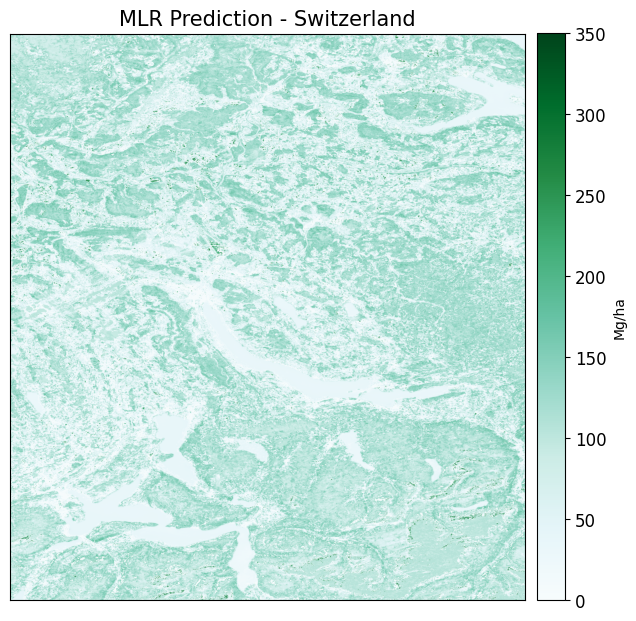

In [ ]:
# No need t run experiments in this bc mathematically deterministic
_, mlr_runtime, mlr_rmse, mlr_r2 = m.mlr(swiss_X_train, swiss_y_train, swiss_X_test, swiss_y_test, 
                                         swiss_X_2d, swiss_height, swiss_width, output=False)

if True:  # SWISS_FIRST_LOCATION_RUN
    with open('data/output/swiss.txt', 'a') as file:
        file.write('MLR control (%s):\n'% EXPERIMENT_RUN)
        file.write(str({'mlr': [mlr_runtime, mlr_rmse, mlr_r2]}))
        file.write('\n\n')

### RF

##### Parameter experiments

In [12]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    rf_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'rf', swiss_X_train, swiss_y_train, 
                                        swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width)

    with open('data/output/swiss.txt', 'a') as file:
        file.write('RF Parameter Experiments Output:\n')
        file.write(str(rf_output))
        file.write('\n\n')
    
    del rf_output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  3.1

##### Input data experiments

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   30.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   49.2s finished


Training Time: 360.72 seconds
RMSE: 48.31289791514536 Mg/ha
R² Score: 0.7556762053515911


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.8min finished


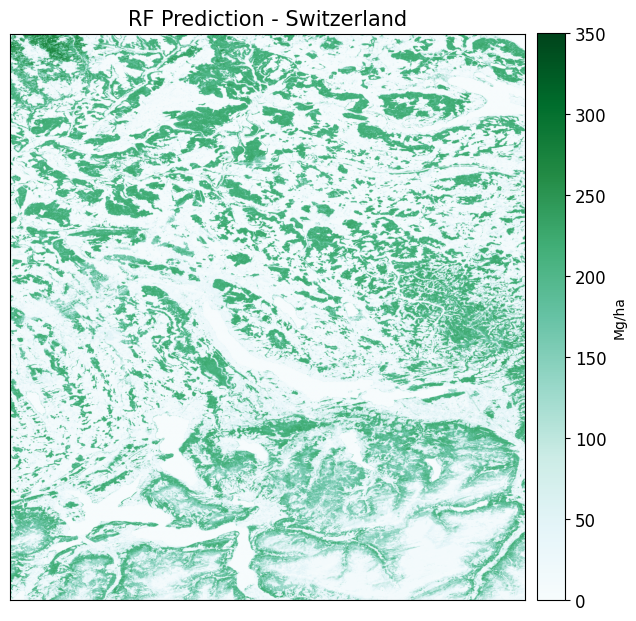

(array([ 87.54995326,   6.58314422,  55.56485814, ..., 211.91084913,
          0.        ,  13.80354461]),
 360.71993613243103,
 48.31289791514536,
 0.7556762053515911)

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_rf = m.parameter_experiments([50], [30], NUM_SIMULATIONS, 'rf', swiss_X_train, swiss_y_train, 
                                        swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width)
    
    with open('data/output/swiss.txt', 'a') as file:
        file.write('RF Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_rf))
        file.write('\n\n')
    
    del input_experiment_output_rf

# m.rf(swiss_X_train, swiss_y_train, swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width, output=True, num_trees=50, max_tree_depth=30)

### GBT

##### Parameter experiments

Training Time: 1407.46 seconds
RMSE: 44.06959915161133 Mg/ha
R² Score: 0.7967092990875244


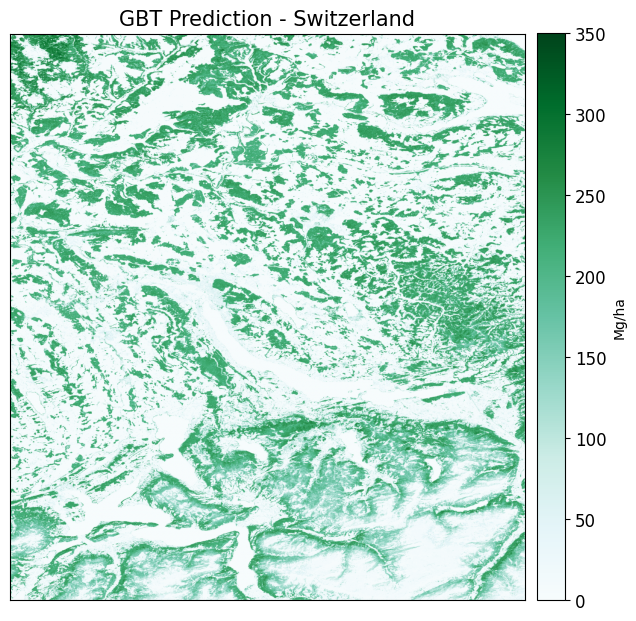

(array([ 1.13060844e+02,  1.90142460e+01,  5.33389587e+01, ...,
         2.22530746e+02, -4.44539764e-04,  1.68147144e+01], dtype=float32),
 1407.4573321342468,
 44.06959915161133,
 0.7967092990875244)

In [ ]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    gbt_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'gbt', swiss_X_train, swiss_y_train, 
                                        swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width)

    with open('data/output/swiss.txt', 'a') as file:
        file.write('GBT Parameter Experiments Output:\n')
        file.write(str(gbt_output))
        file.write('\n\n')
    
    del gbt_output

# m.gbt(swiss_X_train, swiss_y_train, swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width, output=True, num_trees=50, max_tree_depth=30)

### CNNS

In [14]:
arch_used = '2simple'
cnn_model, cnn_runtime, cnn_rmse, cnn_r2 = m.cnn(swiss_combined, swiss_ref_data, output=False, architecture=arch_used)

with open('data/output/swiss.txt', 'a') as file:
    file.write('CNN Parameter Experiments Output:\n')
    file.write(str({arch_used: [[cnn_runtime], [cnn_rmse], [cnn_r2]]}))
    file.write('\n\n')

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - cnn_r2_score: 0.0095 - loss: 15921.2910 - root_mean_squared_error: 126.1796
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 198s 198s/step - cnn_r2_score: 4.7058e-04 - loss: 14817.0146 - root_mean_squared_error: 121.7252
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - cnn_r2_score: 0.0015 - loss: 12164.9229 - root_mean_squared_error: 110.2947
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 209s 209s/step - cnn_r2_score: 9.9648e-04 - loss: 10121.6973 - root_mean_squared_error: 100.6066
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - cnn_r2_score: 5.6101e-05 - loss: 11328.8389 - root_mean_squared_error: 106.4370
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - cnn_r2_score: 7.5231e-05 - loss: 9752.8477 - root_mean_squared_error: 98.7565
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 204s 204s/step - cnn_r2_score: 9.4567e-04 - loss: 10283.1367 - root_mean_squared_error: 101.4058
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 209s 209s/step - cnn_r2_score: 0.0029 - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


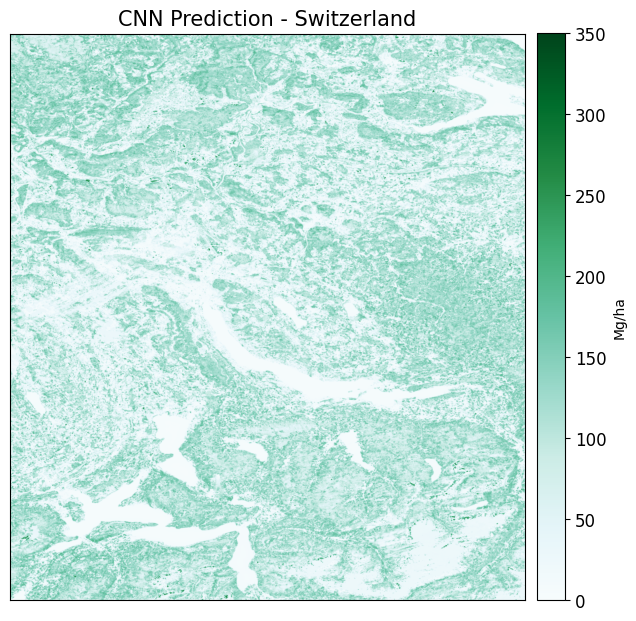

In [13]:
import plotting as p

predicted_output = cnn_model.predict(swiss_combined)

p.plot_raster(predicted_output[0], 'CNN Prediction - Switzerland', 'BuGn', normalized=False, cbar_label='Mg/ha')